In [1]:
!pip install wfdb matplotlib seaborn scikit-learn scipy torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 788.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
import wfdb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.signal import butter, filtfilt
import warnings
warnings.filterwarnings('ignore')

In [3]:
torch.manual_seed(42)
np.random.seed(42)

In [4]:
class ECGDataset(Dataset):
    """Custom Dataset for ECG signals"""

    def __init__(self, signals, labels):
        self.signals = torch.FloatTensor(signals)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        return self.signals[idx], self.labels[idx]


✅ ECG Dataset class defined


In [5]:
class ECGPreprocessor:
    """ECG Signal Preprocessing Pipeline"""

    def __init__(self, fs=360, window_size=1800):  # 5 seconds at 360 Hz
        self.fs = fs
        self.window_size = window_size
        self.label_encoder = LabelEncoder()

    def butter_bandpass_filter(self, data, lowcut=0.5, highcut=50, order=4):
        """Apply Butterworth bandpass filter"""
        nyquist = 0.5 * self.fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        return filtfilt(b, a, data)

    def normalize_signal(self, signal):
        """Z-score normalization"""
        return (signal - np.mean(signal)) / (np.std(signal) + 1e-8)

    def segment_signal(self, signal, overlap=0.5):
        """Segment signal into fixed-length windows with overlap"""
        step = int(self.window_size * (1 - overlap))
        segments = []

        for i in range(0, len(signal) - self.window_size + 1, step):
            segment = signal[i:i + self.window_size]
            if len(segment) == self.window_size:
                segments.append(segment)

        return np.array(segments)

    def preprocess_record(self, record_name, data_path='./mitdb'):
        """Preprocess a single ECG record"""
        try:
            # Read ECG record
            record = wfdb.rdrecord(os.path.join(data_path, record_name))
            annotation = wfdb.rdann(os.path.join(data_path, record_name), 'atr')

            # Use lead II (channel 0) or lead V1 (channel 1)
            signal = record.p_signal[:, 0]

            # Apply filtering
            filtered_signal = self.butter_bandpass_filter(signal)

            # Normalize
            normalized_signal = self.normalize_signal(filtered_signal)

            # Segment into windows
            segments = self.segment_signal(normalized_signal)

            # Create labels for each segment (simplified approach)
            beat_types = annotation.symbol
            dominant_beat = max(set(beat_types), key=beat_types.count)

            # Map beat annotations to classes
            class_mapping = {
                'N': 'Normal',      # Normal beat
                'L': 'Normal',      # Left bundle branch block beat
                'R': 'Normal',      # Right bundle branch block beat
                'A': 'AFib',        # Atrial premature beat
                'a': 'AFib',        # Aberrated atrial premature beat
                'V': 'VT',          # Premature ventricular contraction
                'E': 'VT',          # Ventricular escape beat
                '/': 'Other',       # Paced beat
                'f': 'Other',       # Fusion of ventricular and normal beat
                'Q': 'Other'        # Unclassifiable beat
            }

            beat_class = class_mapping.get(dominant_beat, 'Other')
            labels = [beat_class] * len(segments)

            return segments, labels

        except Exception as e:
            print(f"Error processing record {record_name}: {e}")
            return None, None


In [8]:
class CNNRNNClassifier(nn.Module):
    """CNN-RNN Hybrid Model for ECG Classification"""

    def __init__(self, input_size=1800, num_classes=4, hidden_size=128):
        super(CNNRNNClassifier, self).__init__()

        # CNN layers for local pattern extraction
        self.conv1 = nn.Conv1d(1, 32, kernel_size=7, padding=3)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm1d(32)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(128)

        self.pool = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.3)

        # Calculate CNN output size
        cnn_output_size = input_size // (2 ** 3)  # 3 pooling layers

        # RNN layers for temporal modeling
        self.lstm = nn.LSTM(128, hidden_size, batch_first=True, bidirectional=True)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # CNN feature extraction
        x = x.unsqueeze(1)  # Add channel dimension

        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.dropout(x)

        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)

        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.dropout(x)

        # Prepare for RNN
        x = x.transpose(1, 2)  # (batch, seq_len, features)

        # RNN processing
        lstm_out, _ = self.lstm(x)

        # Global average pooling over sequence length
        x = torch.mean(lstm_out, dim=1)

        # Classification
        x = self.classifier(x)

        return x

In [9]:
model = CNNRNNClassifier(input_size=1800, num_classes=4, hidden_size=128)
total_params = sum(p.numel() for p in model.parameters())
print(f"CNN-RNN model defined with {total_params:,} parameters")

CNN-RNN model defined with 316,612 parameters


In [10]:
class ECGTrainer:
    """Training and Evaluation Pipeline"""

    def __init__(self, model, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model.to(device)
        self.device = device
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, patience=5, factor=0.5, verbose=True
        )

        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []

    def train_epoch(self, train_loader):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(self.device), target.to(self.device)

            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.criterion(output, target)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()

            if batch_idx % 10 == 0:
                print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

        return total_loss / len(train_loader)

    def validate(self, val_loader):
        """Validate the model"""
        self.model.eval()
        total_loss = 0
        correct = 0
        predictions = []
        targets = []

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                loss = self.criterion(output, target)
                total_loss += loss.item()

                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()

                predictions.extend(pred.cpu().numpy())
                targets.extend(target.cpu().numpy())

        accuracy = correct / len(val_loader.dataset)
        avg_loss = total_loss / len(val_loader)

        return avg_loss, accuracy, predictions, targets

    def train(self, train_loader, val_loader, epochs=50):
        """Full training loop"""
        best_val_acc = 0
        patience_counter = 0

        for epoch in range(epochs):
            print(f'\nEpoch {epoch+1}/{epochs}')
            print('-' * 50)

            # Training
            train_loss = self.train_epoch(train_loader)

            # Validation
            val_loss, val_acc, val_preds, val_targets = self.validate(val_loader)

            # Learning rate scheduling
            self.scheduler.step(val_loss)

            # Store metrics
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)

            print(f'Train Loss: {train_loss:.4f}')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

            # Early stopping
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                torch.save(self.model.state_dict(), 'best_ecg_model.pth')
                print(f'New best model saved! Val Acc: {best_val_acc:.4f}')
            else:
                patience_counter += 1

            if patience_counter >= 10:
                print('Early stopping triggered!')
                break

        return val_preds, val_targets

    def plot_training_history(self):
        """Plot training metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Loss plot
        ax1.plot(self.train_losses, label='Train Loss')
        ax1.plot(self.val_losses, label='Val Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)

        # Accuracy plot
        ax2.plot(self.val_accuracies, label='Val Accuracy')
        ax2.set_title('Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()


In [11]:
def create_synthetic_data(n_samples=1000, signal_length=1800):
    """Create synthetic ECG data for demonstration"""
    np.random.seed(42)

    signals = []
    labels = []

    print(f"Generating {n_samples} synthetic ECG signals...")

    for i in range(n_samples):
        # Create synthetic ECG-like signals
        t = np.linspace(0, 5, signal_length)  # 5 seconds

        if i % 4 == 0:  # Normal
            signal = np.sin(2 * np.pi * 1.2 * t) + 0.3 * np.sin(2 * np.pi * 2.4 * t)
            label = 'Normal'
        elif i % 4 == 1:  # AFib
            noise_factor = 0.8
            signal = np.sin(2 * np.pi * 1.2 * t) + noise_factor * np.random.randn(signal_length)
            label = 'AFib'
        elif i % 4 == 2:  # VT
            signal = 2 * np.sin(2 * np.pi * 3 * t) + 0.5 * np.sin(2 * np.pi * 6 * t)
            label = 'VT'
        else:  # Other
            signal = 0.5 * np.sin(2 * np.pi * 0.8 * t) + np.random.randn(signal_length) * 0.3
            label = 'Other'

        # Add some noise
        signal += np.random.randn(signal_length) * 0.1

        # Normalize
        signal = (signal - np.mean(signal)) / (np.std(signal) + 1e-8)

        signals.append(signal)
        labels.append(label)

        if (i + 1) % 250 == 0:
            print(f"Generated {i + 1}/{n_samples} signals")

    return np.array(signals), np.array(labels)

# Generate synthetic data
signals, labels = create_synthetic_data(n_samples=2000, signal_length=1800)
print(f"Generated {len(signals)} synthetic ECG signals")

Generating 2000 synthetic ECG signals...
Generated 250/2000 signals
Generated 500/2000 signals
Generated 750/2000 signals
Generated 1000/2000 signals
Generated 1250/2000 signals
Generated 1500/2000 signals
Generated 1750/2000 signals
Generated 2000/2000 signals
Generated 2000 synthetic ECG signals


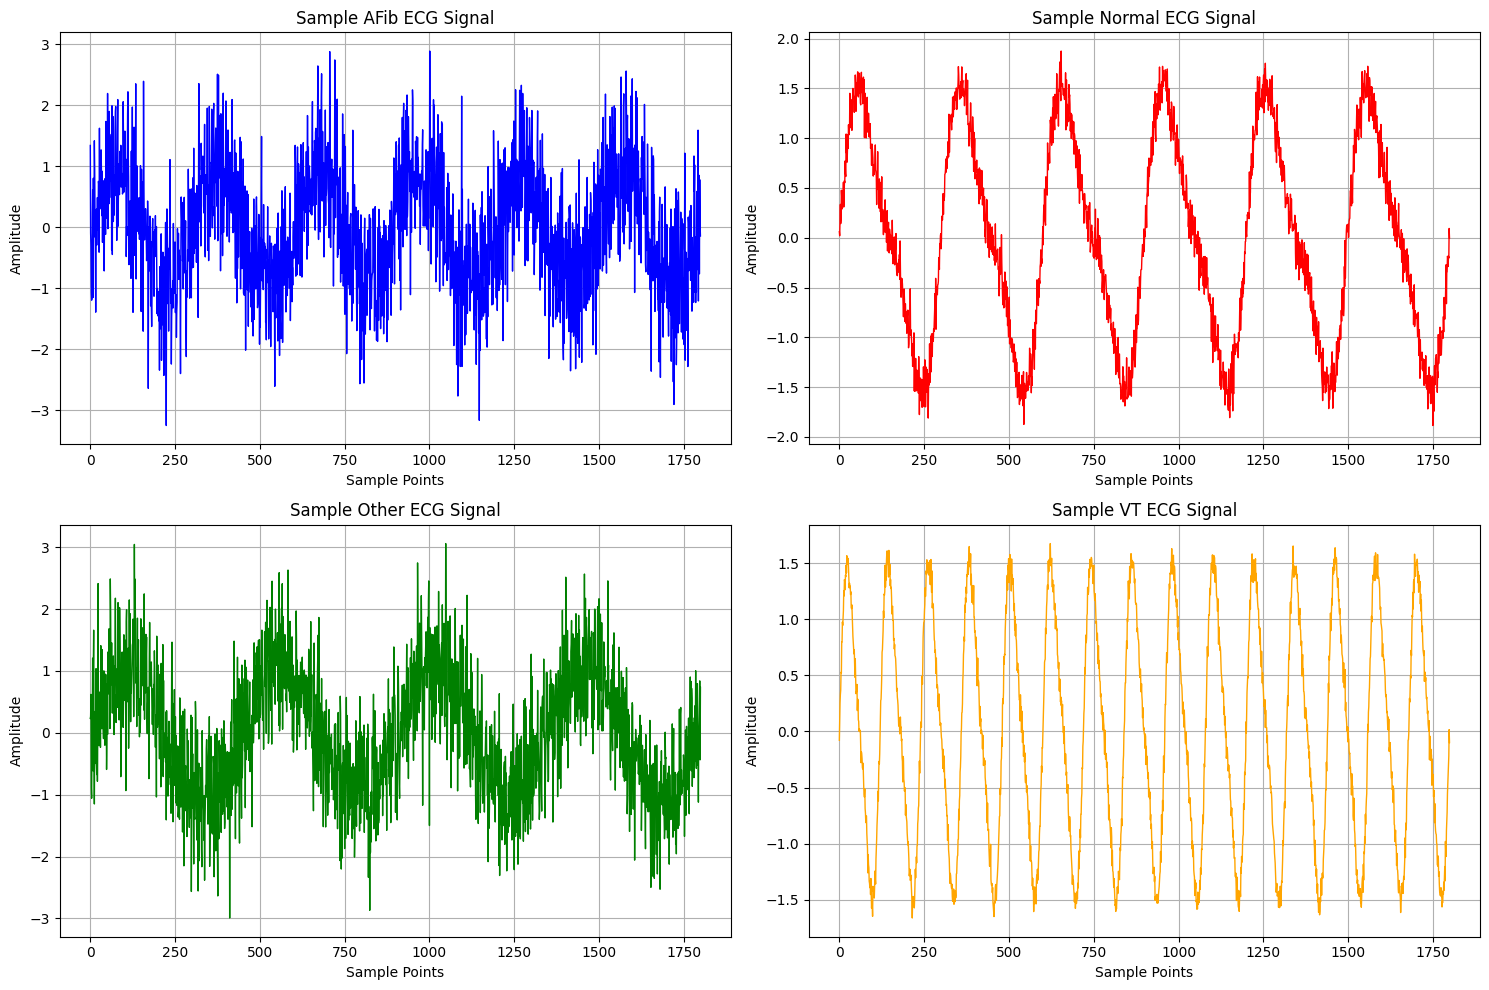

In [12]:
# Plot sample signals from each class
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

unique_labels = np.unique(labels)
colors = ['blue', 'red', 'green', 'orange']

for i, label in enumerate(unique_labels):
    idx = np.where(labels == label)[0][0]
    axes[i].plot(signals[idx], color=colors[i], linewidth=1)
    axes[i].set_title(f'Sample {label} ECG Signal')
    axes[i].set_xlabel('Sample Points')
    axes[i].set_ylabel('Amplitude')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

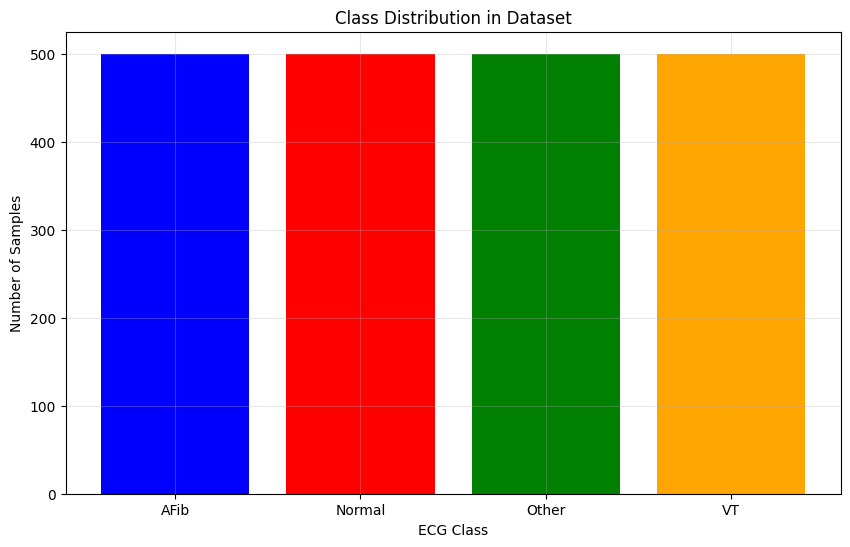

In [13]:
# Class distribution
plt.figure(figsize=(10, 6))
unique, counts = np.unique(labels, return_counts=True)
plt.bar(unique, counts, color=['blue', 'red', 'green', 'orange'])
plt.title('Class Distribution in Dataset')
plt.xlabel('ECG Class')
plt.ylabel('Number of Samples')
plt.grid(True, alpha=0.3)
plt.show()


In [14]:
# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
class_names = label_encoder.classes_
num_classes = len(class_names)

print(f"Dataset: {len(signals)} samples")
print(f"Classes: {class_names}")
print(f"Signal length: {signals.shape[1]} samples")
print(f"Number of classes: {num_classes}")


Dataset: 2000 samples
Classes: ['AFib' 'Normal' 'Other' 'VT']
Signal length: 1800 samples
Number of classes: 4


In [15]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    signals, encoded_labels, test_size=0.2, stratify=encoded_labels, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

print(f"\nData splits:")
print(f"Train: {len(X_train)} samples")
print(f"Validation: {len(X_val)} samples")
print(f"Test: {len(X_test)} samples")


Data splits:
Train: 1280 samples
Validation: 320 samples
Test: 400 samples


In [16]:
# Create datasets and dataloaders
train_dataset = ECGDataset(X_train, y_train)
val_dataset = ECGDataset(X_val, y_val)
test_dataset = ECGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [17]:
# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = CNNRNNClassifier(
    input_size=signals.shape[1],
    num_classes=num_classes,
    hidden_size=128
)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")


Using device: cpu
Model parameters: 316,612


In [18]:
# Initialize trainer
trainer = ECGTrainer(model, device)


In [19]:
# Train the model
val_preds, val_targets = trainer.train(train_loader, val_loader, epochs=20)



Epoch 1/20
--------------------------------------------------
Batch 0/40, Loss: 1.3914
Batch 10/40, Loss: 0.9978
Batch 20/40, Loss: 0.7758
Batch 30/40, Loss: 0.8124
Train Loss: 0.9025
Val Loss: 0.6695, Val Acc: 0.7469
New best model saved! Val Acc: 0.7469

Epoch 2/20
--------------------------------------------------
Batch 0/40, Loss: 0.7916
Batch 10/40, Loss: 0.6791
Batch 20/40, Loss: 0.5994
Batch 30/40, Loss: 0.7214
Train Loss: 0.6999
Val Loss: 0.6059, Val Acc: 0.7500
New best model saved! Val Acc: 0.7500

Epoch 3/20
--------------------------------------------------
Batch 0/40, Loss: 0.7321
Batch 10/40, Loss: 0.6034
Batch 20/40, Loss: 0.5952
Batch 30/40, Loss: 0.5638
Train Loss: 0.6526
Val Loss: 0.4999, Val Acc: 0.7438

Epoch 4/20
--------------------------------------------------
Batch 0/40, Loss: 0.9148
Batch 10/40, Loss: 0.7492
Batch 20/40, Loss: 0.6716
Batch 30/40, Loss: 0.5640
Train Loss: 0.6511
Val Loss: 0.5022, Val Acc: 0.7500

Epoch 5/20
------------------------------------

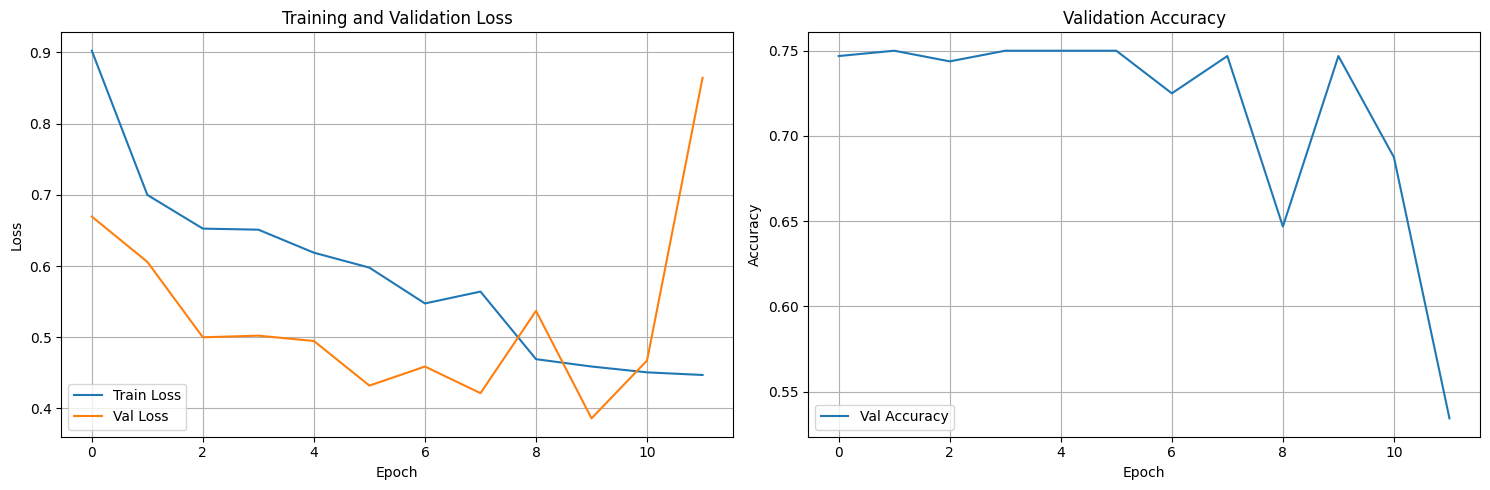

In [20]:
trainer.plot_training_history()

In [21]:
def evaluate_model(y_true, y_pred, class_names):
    """Comprehensive model evaluation"""
    # Classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # F1 scores
    f1_scores = f1_score(y_true, y_pred, average=None)
    for i, class_name in enumerate(class_names):
        print(f"F1 Score for {class_name}: {f1_scores[i]:.4f}")

    print(f"Macro F1 Score: {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"Weighted F1 Score: {f1_score(y_true, y_pred, average='weighted'):.4f}")


In [22]:
# Load best model
model.load_state_dict(torch.load('best_ecg_model.pth'))
test_loss, test_acc, test_preds, test_targets = trainer.validate(test_loader)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


Test Accuracy: 0.7500
Test Loss: 0.6043


Classification Report:
              precision    recall  f1-score   support

        AFib       1.00      1.00      1.00       100
      Normal       0.00      0.00      0.00       100
       Other       1.00      1.00      1.00       100
          VT       0.50      1.00      0.67       100

    accuracy                           0.75       400
   macro avg       0.62      0.75      0.67       400
weighted avg       0.62      0.75      0.67       400



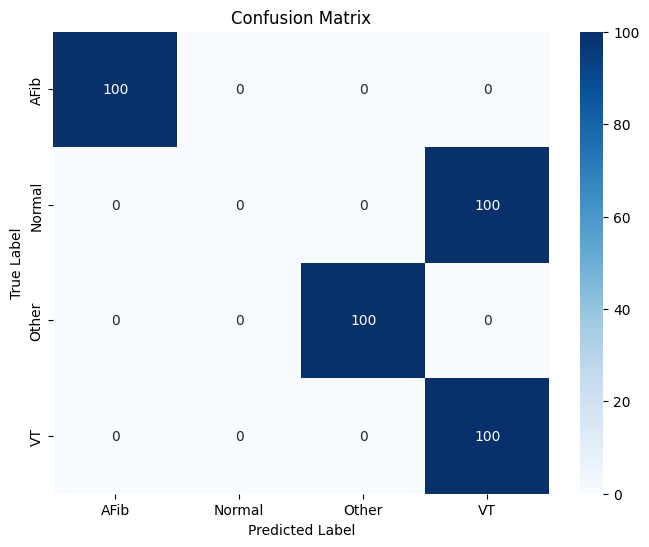

F1 Score for AFib: 1.0000
F1 Score for Normal: 0.0000
F1 Score for Other: 1.0000
F1 Score for VT: 0.6667
Macro F1 Score: 0.6667
Weighted F1 Score: 0.6667


In [23]:
# Detailed evaluation
evaluate_model(test_targets, test_preds, class_names)

In [24]:
def show_sample_predictions(model, test_loader, class_names, num_samples=8):
    model.eval()
    samples_shown = 0

    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.ravel()

    with torch.no_grad():
        for data, target in test_loader:
            if samples_shown >= num_samples:
                break

            data = data.to(device)
            output = model(data)
            pred = output.argmax(dim=1)

            for i in range(min(len(data), num_samples - samples_shown)):
                signal = data[i].cpu().numpy()
                true_label = class_names[target[i]]
                pred_label = class_names[pred[i]]
                confidence = torch.softmax(output[i], dim=0).max().item()

                axes[samples_shown].plot(signal, color='blue' if true_label == pred_label else 'red')
                axes[samples_shown].set_title(
                    f'True: {true_label}\nPred: {pred_label} ({confidence:.2f})',
                    color='green' if true_label == pred_label else 'red'
                )
                axes[samples_shown].grid(True, alpha=0.3)

                samples_shown += 1
                if samples_shown >= num_samples:
                    break

    plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)', fontsize=16)
    plt.tight_layout()
    plt.show()


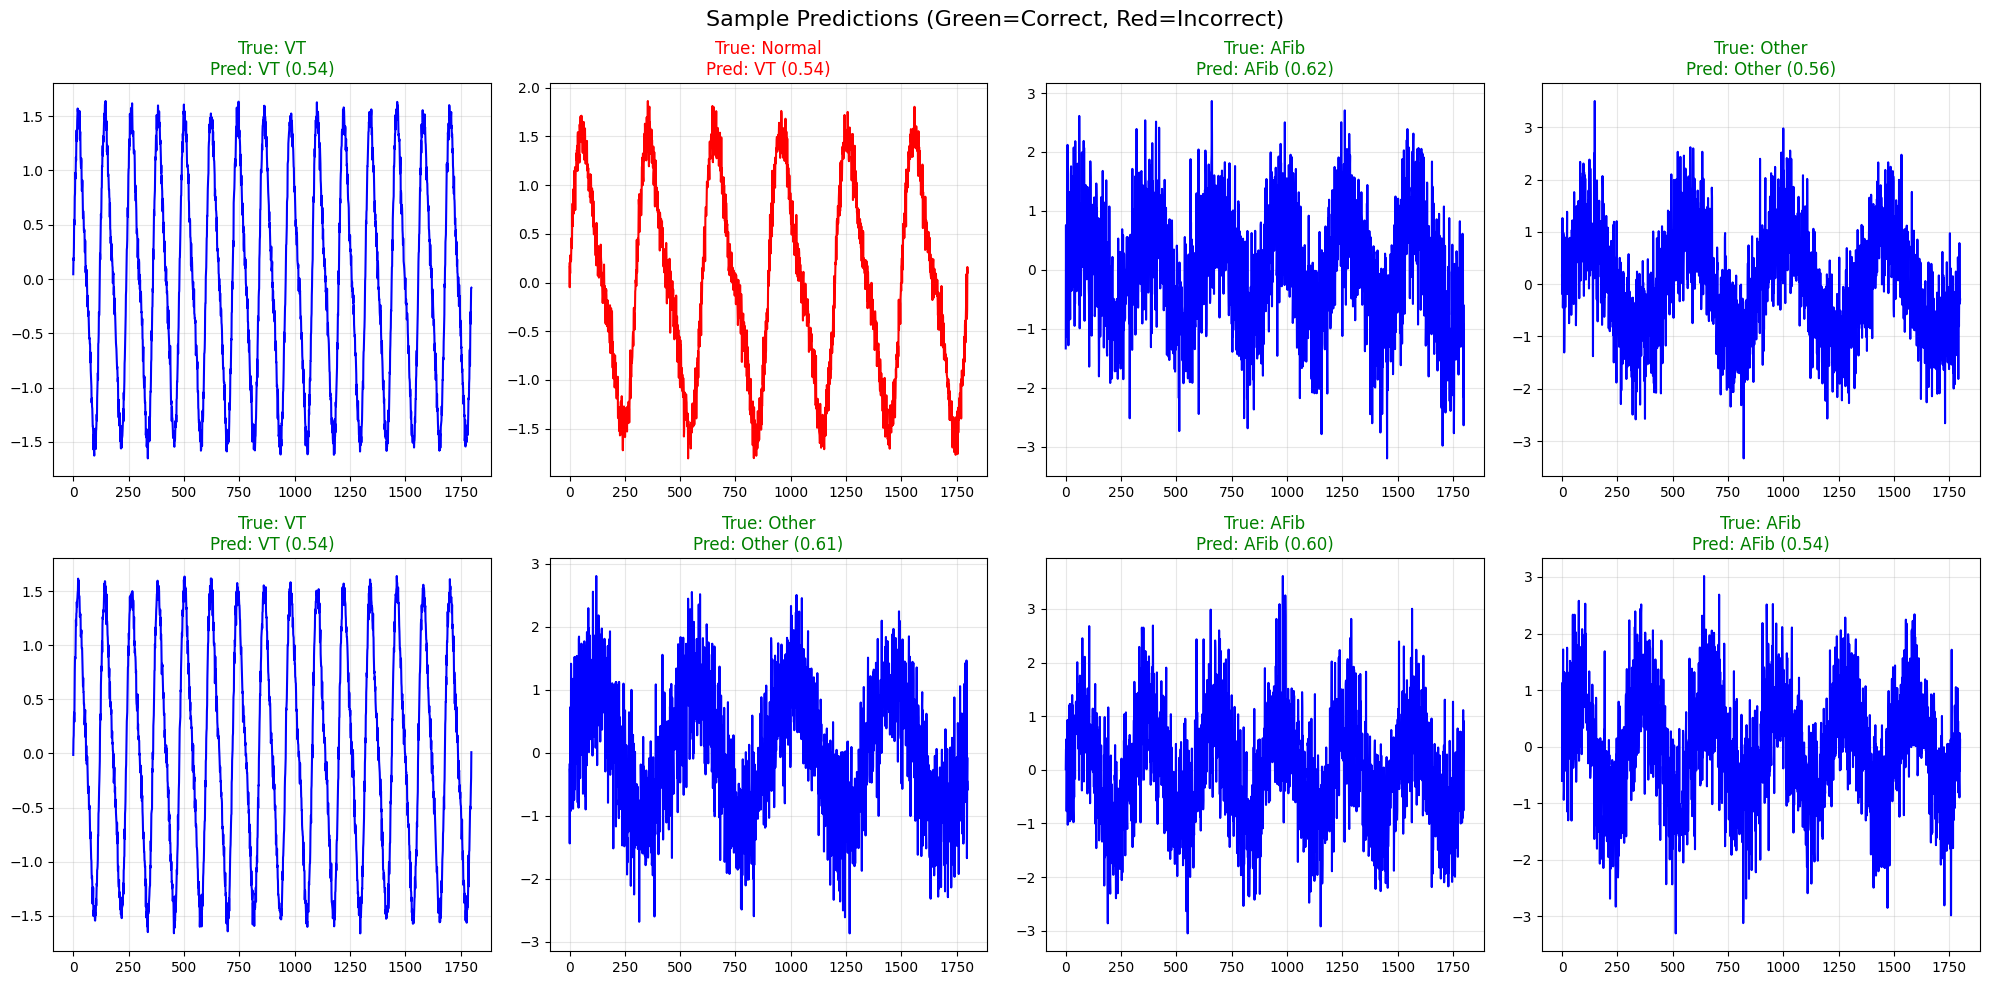

In [25]:
show_sample_predictions(model, test_loader, class_names)

In [26]:
# Save complete model and configuration
model_save_dict = {
    'model_state_dict': model.state_dict(),
    'label_encoder': label_encoder,
    'model_config': {
        'input_size': signals.shape[1],
        'num_classes': num_classes,
        'hidden_size': 128
    },
    'class_names': class_names,
    'test_accuracy': test_acc,
    'training_history': {
        'train_losses': trainer.train_losses,
        'val_losses': trainer.val_losses,
        'val_accuracies': trainer.val_accuracies
    }
}

torch.save(model_save_dict, 'ecg_classifier_complete.pth')

print(f"Final test accuracy: {test_acc:.4f}")

Final test accuracy: 0.7500
